# Rockall Trough mooring - gab filling and extrapolation

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.set_paths as sps
import src.features.RT_EOF_functions as rt_eof

import src.features.RT_visualise as rtv

/home/sa05af/.conda/envs/af_python3_12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../src/features/RT_transport.py:9: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import seaborn as sns
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt



## set some plot parameters

In [3]:
sns.set_theme(context='notebook',
              style="whitegrid",
              palette="colorblind",
              rc={"axes.axisbelow": False}
             )
plt.rcParams['lines.linewidth'] = 1.4 

### Set in- and output path

In [4]:
date_str_start = '201407'
date_str_end = '202407'
fn_version = 'v1'
script_name = f"04_afox_Rockall_Trough_moorings_data_prep_{date_str_start[:-2]}_{date_str_end[:-2]}_v0"
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"


file_name_in_grid = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_version}.nc"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [5]:
# output data
data_out_path = (sps.local_data_dir/f"{script_name}")
Path(data_out_path).mkdir(parents=True, exist_ok=True)
file_name_out = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_version}.1.nc"

## Parameter Preamble

In [6]:
# Praemble for despike time series after vertical extrapolation to surface
stddy_tol  = 10; # set max velocities range (diff velocity pm stddy_tol)
std_win    = 3.5; # 3.5 * std of the time series (median pm std_win)
nloop    = 5; # max number of despiking repetitions
graphics   = False; #y if plots of despiking on, 'n' if off

## Load Data and prepare for calculations

In [7]:
ds_cruises = rtd.load_cruise_list()

In [8]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_grid))

In [9]:
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

In [10]:
# remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500,method='nearest').notnull().drop_vars('PRES'),drop=True)

## Supplementary data

## Plot preprocess data

In [11]:
def plot_moored_obs(ds_RT,moor,var,ds_RT_stacked,savefig=False):
    ds_cruises = rtd.load_cruise_list()
    fig,axs = plt.subplots(2,1,figsize=[16,8],sharex=True)

    if var=='velocity':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.U_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_EAST_1_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_EAST_1_UV',
                                                     add_legend=False,lw=0.5)

        elif moor=='WB1':
            ax = axs[0]
            ds_RT.U_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_WEST_1_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_1_UV',
                                                     add_legend=False,lw=0.5)

        elif moor=='WB2':
            ax = axs[0]
            ds_RT.U_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            for ax in axs:
                ds_RT_stacked.PS_WEST_2_UV.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_2_UV',
                                                     add_legend=False,lw=0.5)
    
    elif var=='hydrography':
        sigma_contours = [27.2,27.5, 27.7]
        # manual_locations = [(-12,100),(-12,900),(-12,1250)]
        if moor=='EB1':
            sigma = gsw.sigma0(ds_RT.SG_EAST, ds_RT.TG_EAST)
            ax = axs[0]
            ds_RT.TG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            ax.clabel(CS) #,manual=manual_locations)
            ax = axs[1]
            ds_RT.SG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            for ax in axs:
                ds_RT_stacked.PS_EAST_TS.plot.line('k',ax=ax,x='TIME',hue='ZS_EAST_TS',
                                                   add_legend=False,lw=0.5)
        elif moor=='WB1':
            ax = axs[0]
            sigma = gsw.sigma0(ds_RT.SG_WEST, ds_RT.TG_WEST)
            ds_RT.TG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            ax = axs[1]
            ds_RT.SG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            CS = sigma.plot.contour(ax=ax,x='TIME',levels=sigma_contours,yincrease=False,colors='w',linewidths =0.5)
            for ax in axs:
                ds_RT_stacked.PS_WEST_TS.plot.line('k',ax=ax,x='TIME',hue='ZS_WEST_TS',
                                                   add_legend=False,lw=0.5)
        

    for ax in axs:
        ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),
                  color='k',linestyle='--')
        ax.set_xlabel('')
        ax.grid()

    for i,text in enumerate(ds_cruises):
        axs[0].annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

    plt.tight_layout()
    
    if savefig:
        outfig = (fig_out_path/f'RT_{moor}_{var}_{date_str_start}_{date_str_end}.png')
        print(f'Figure saved as {outfig}')
        fig.savefig(outfig,bbox_inches='tight')

# EB1

Figure saved as /home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../figures/04_afox_Rockall_Trough_moorings_data_prep_2014_2024_v0/RT_EB1_hydrography_201407_202407.png
Figure saved as /home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../figures/04_afox_Rockall_Trough_moorings_data_prep_2014_2024_v0/RT_EB1_velocity_201407_202407.png


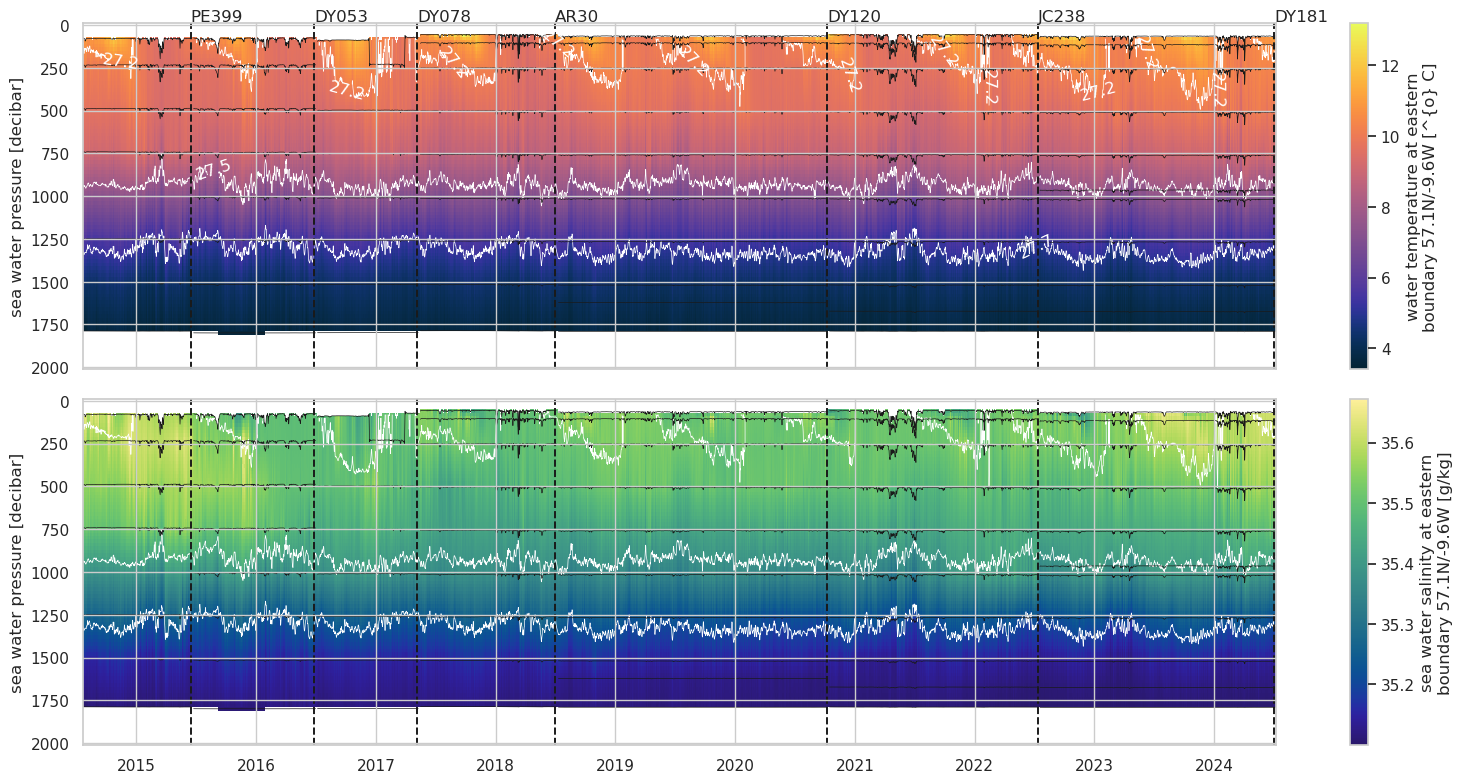

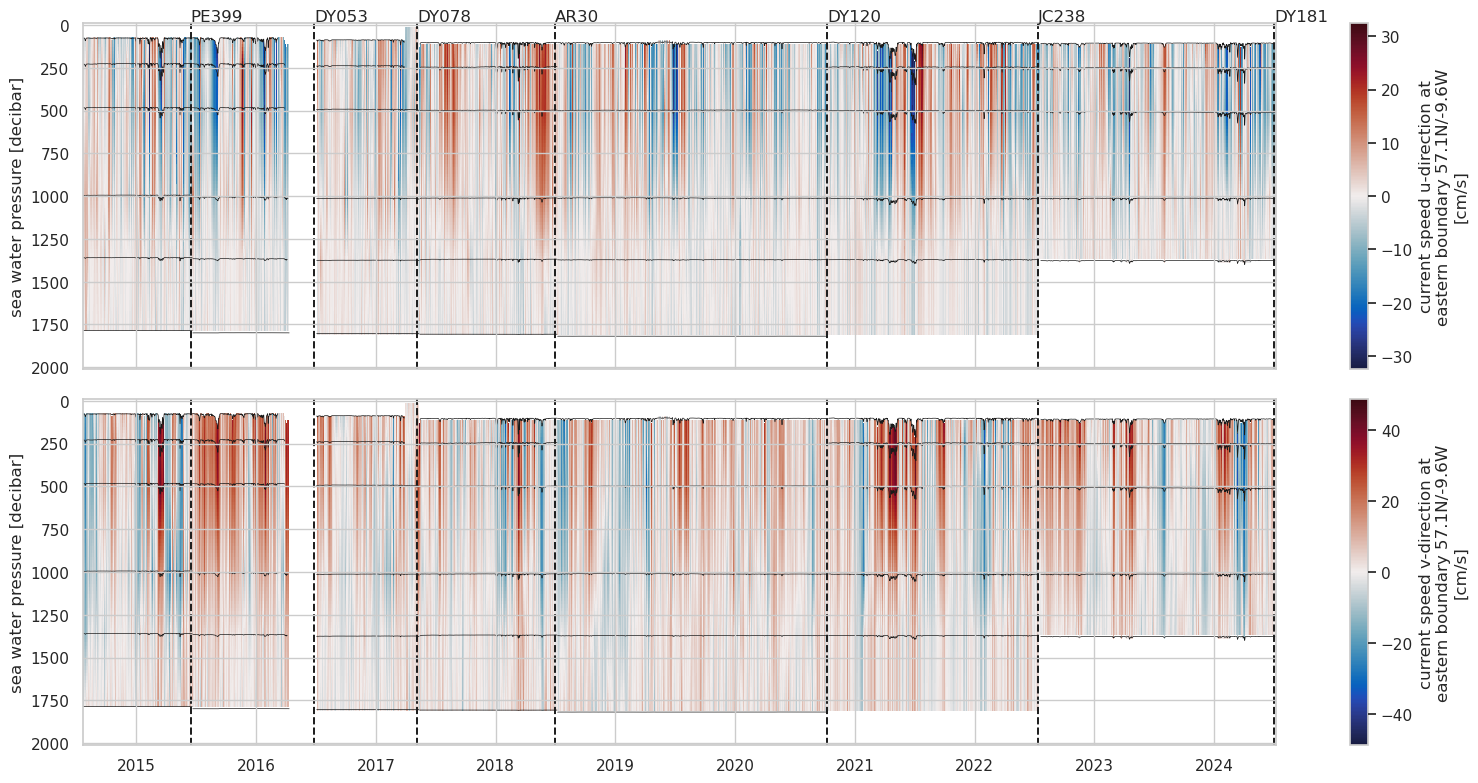

In [12]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_RT_stacked,savefig=True)
plot_moored_obs(ds_RT,'EB1','velocity',ds_RT_stacked,savefig=True)

# WB1

Figure saved as /home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../figures/04_afox_Rockall_Trough_moorings_data_prep_2014_2024_v0/RT_WB1_hydrography_201407_202407.png
Figure saved as /home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../figures/04_afox_Rockall_Trough_moorings_data_prep_2014_2024_v0/RT_WB1_velocity_201407_202407.png


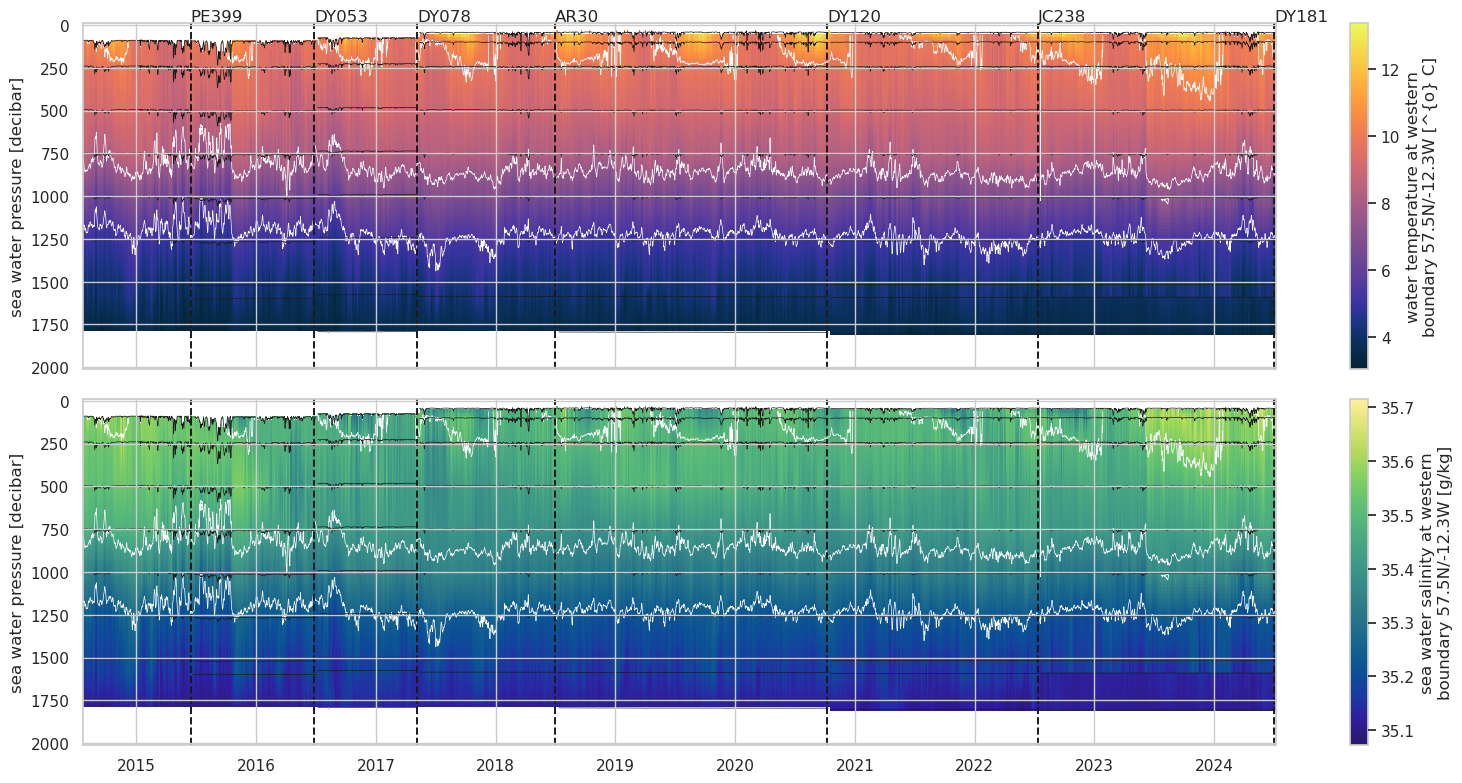

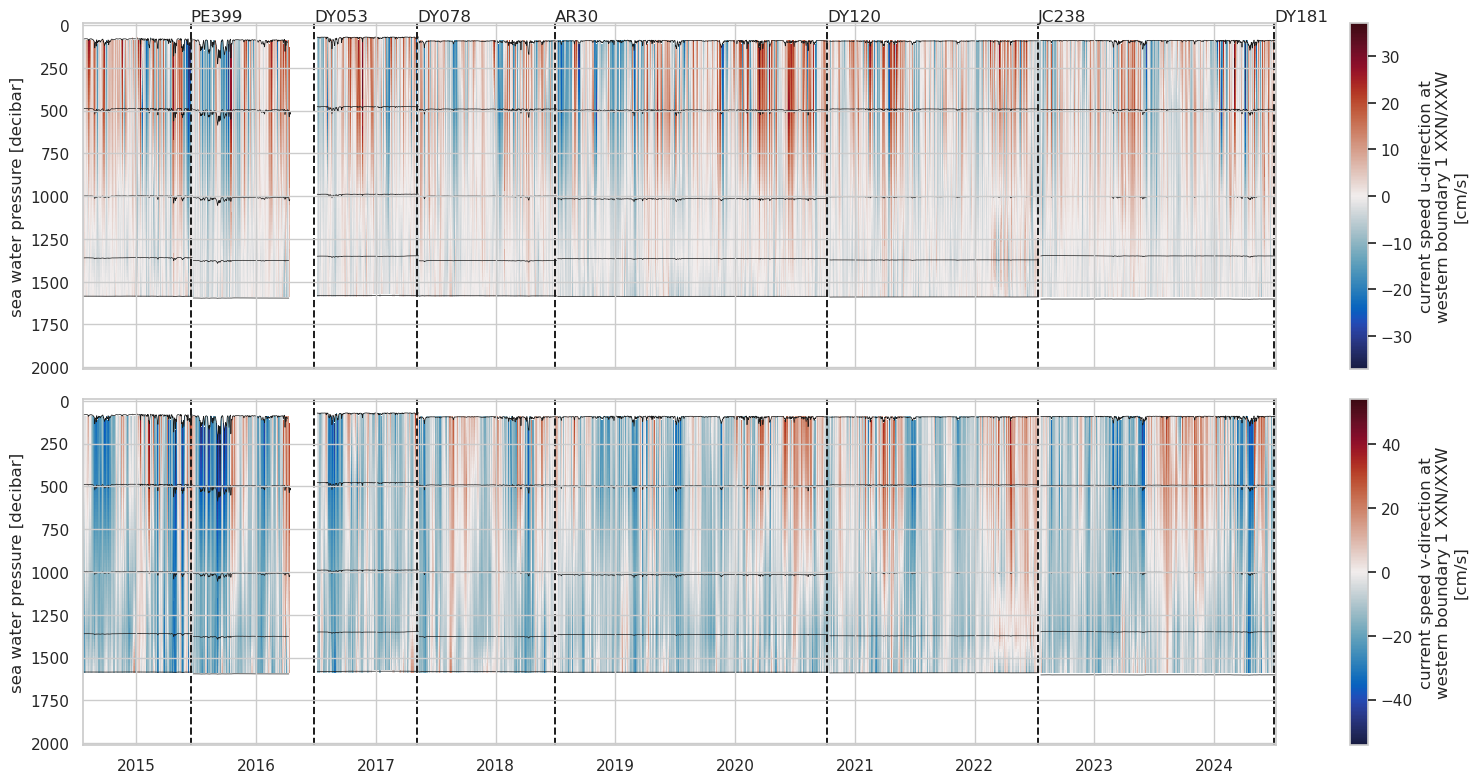

In [13]:
plot_moored_obs(ds_RT,'WB1','hydrography',ds_RT_stacked,savefig=True)
plot_moored_obs(ds_RT,'WB1','velocity',ds_RT_stacked,savefig=True)

# WB2

Figure saved as /home/sa05af/Projects/Rockall_Trough_Transports/notebooks/../figures/04_afox_Rockall_Trough_moorings_data_prep_2014_2024_v0/RT_WB2_velocity_201407_202407.png


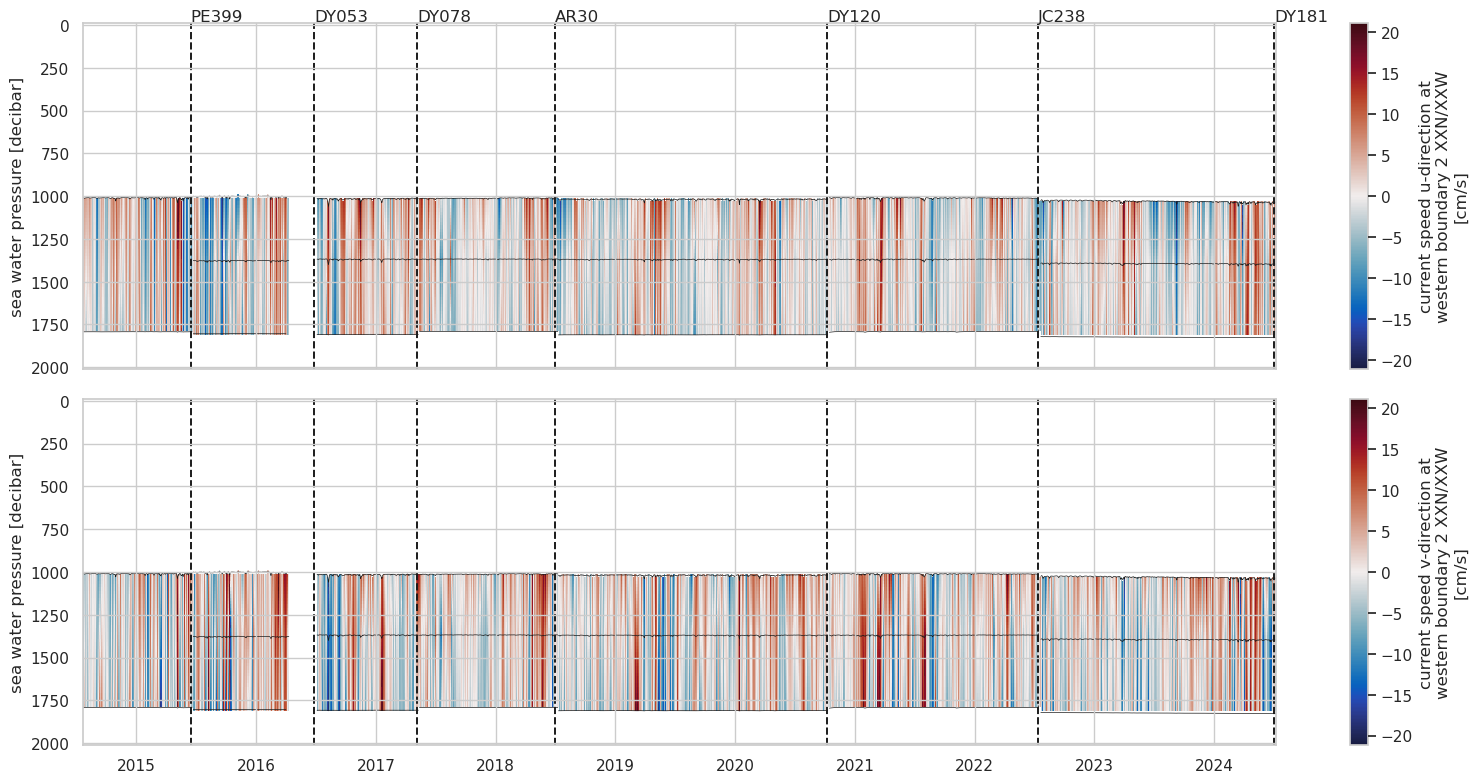

In [14]:
plot_moored_obs(ds_RT,'WB2','velocity',ds_RT_stacked,savefig=True)

## Statistics for gap filling used to created merged product
add ten day lowpass filter

17.10859489440918 10.064220428466797
16.774845123291016 9.884049415588379
16.774836165598796 9.88405196043532
x,y: 0.9511371569542965
RME x, y = 2.4182963371276855
y,y_pred: 0.9511369120648586
RME y, y_pred = 2.3693627748602326


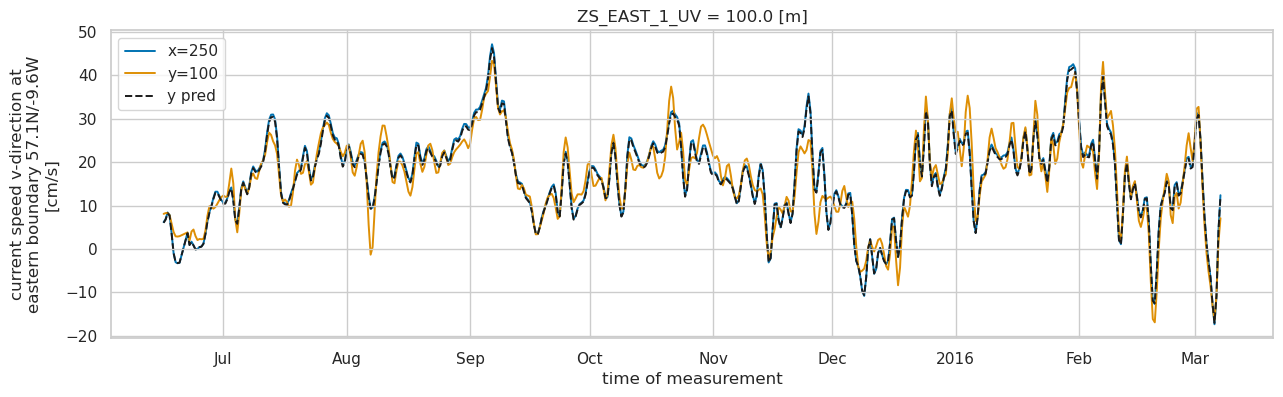

In [15]:
px = 250
py = 100
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

13.6699857711792 9.530810356140137
16.070112228393555 10.515045166015625
16.070110780438224 10.515044893513812
x,y: 0.9605958780192041
RME x, y = 3.0361344814300537
y,y_pred: 0.960595902913378
RME y, y_pred = 2.2543502394357042


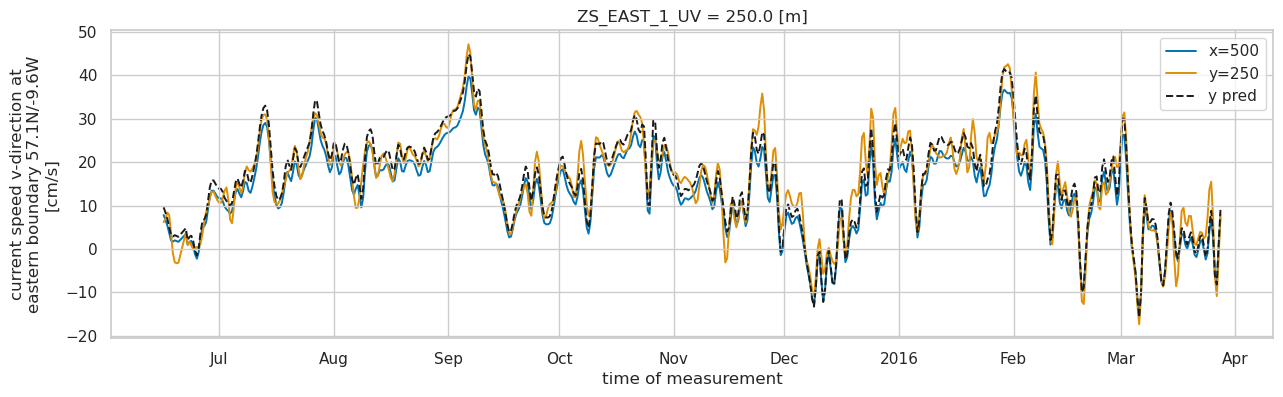

In [16]:
px = 500
py = 250
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

5.906966209411621 6.300337314605713
13.6699857711792 9.530810356140137
13.669978082036689 9.530811314113963
x,y: 0.7916086455027029
RME x, y = 8.324480056762695
y,y_pred: 0.7916085659353505
RME y, y_pred = 4.749921399281043


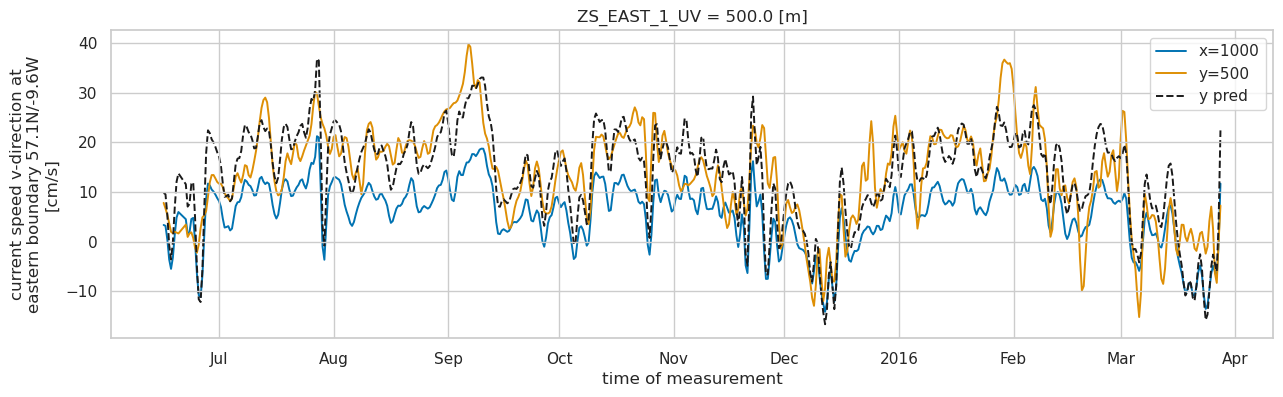

In [17]:
px = 1000
py = 500
day_cutoff = 5
period = ds_cruises.TIME[1:3].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

0.5728609561920166 4.054640769958496
1.231352686882019 4.0731587409973145
1.231352781028447 4.073158820083214
x,y: 0.6054087858595544
RME x, y = 2.9182918071746826
y,y_pred: 0.6054087741047209
RME y, y_pred = 2.882140019467831


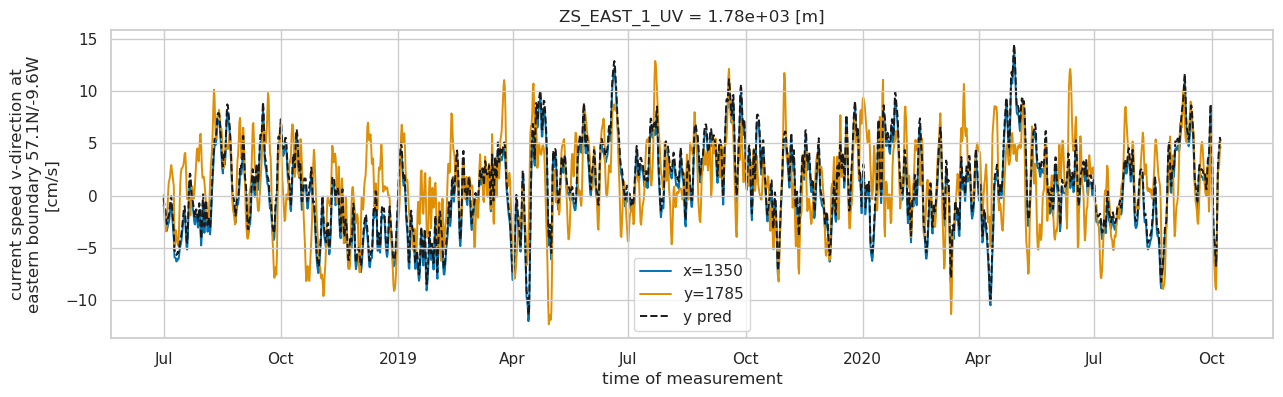

In [18]:
px = 1350
py = 1785
day_cutoff = 5
period = ds_cruises.TIME[[4,5]].values
rtf.plot_correlation_stacked(ds_RT_stacked,px,py,period)

# Linear extrapolation of upper values

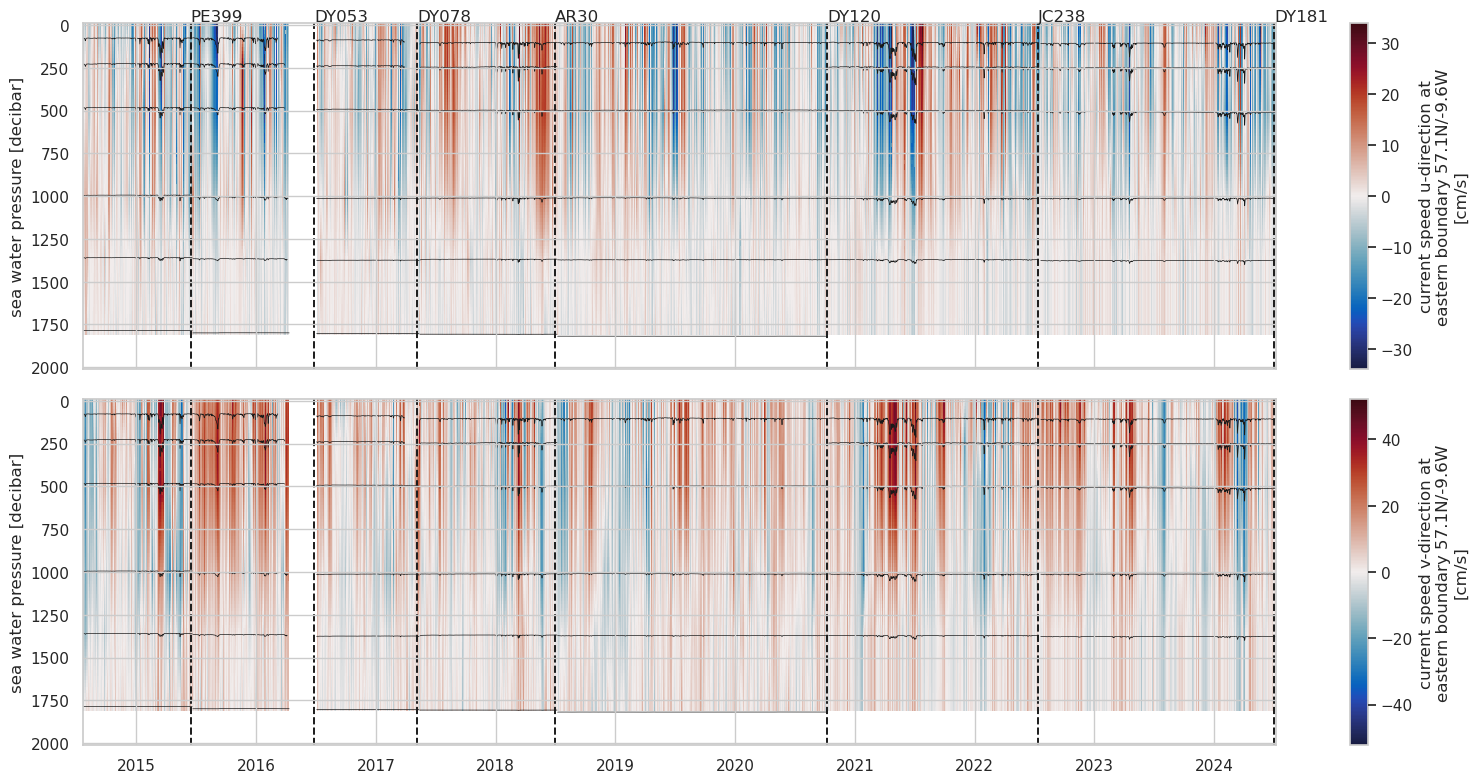

In [19]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'EB1'
ds_RT['V_EAST'] = rtf.CM_linear_upper_values(ds_RT.V_EAST,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_EAST'] = rtf.CM_linear_upper_values(ds_RT.U_EAST,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

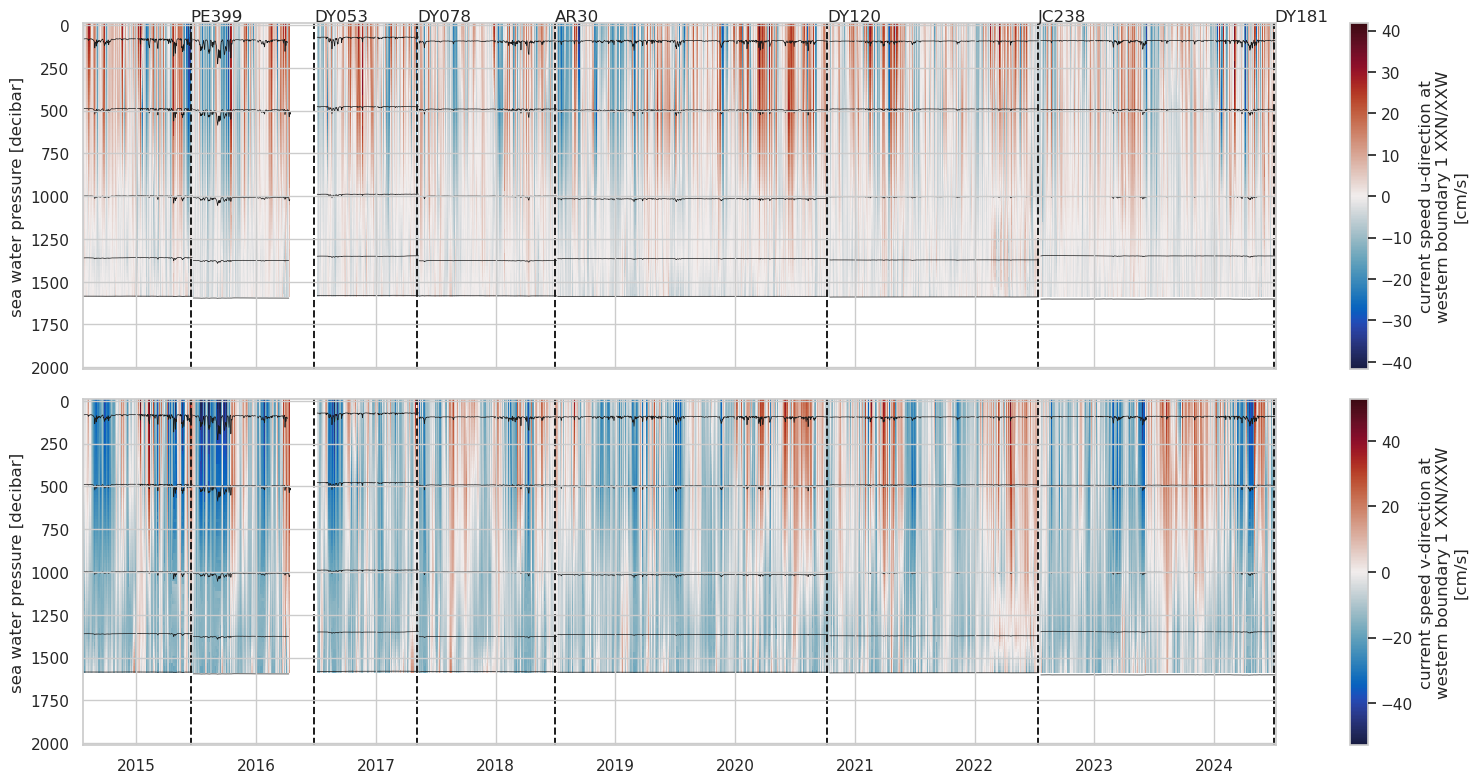

In [20]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'WB1'
ds_RT['V_WEST_1'] = rtf.CM_linear_upper_values(ds_RT.V_WEST_1,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_WEST_1'] = rtf.CM_linear_upper_values(ds_RT.U_WEST_1,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

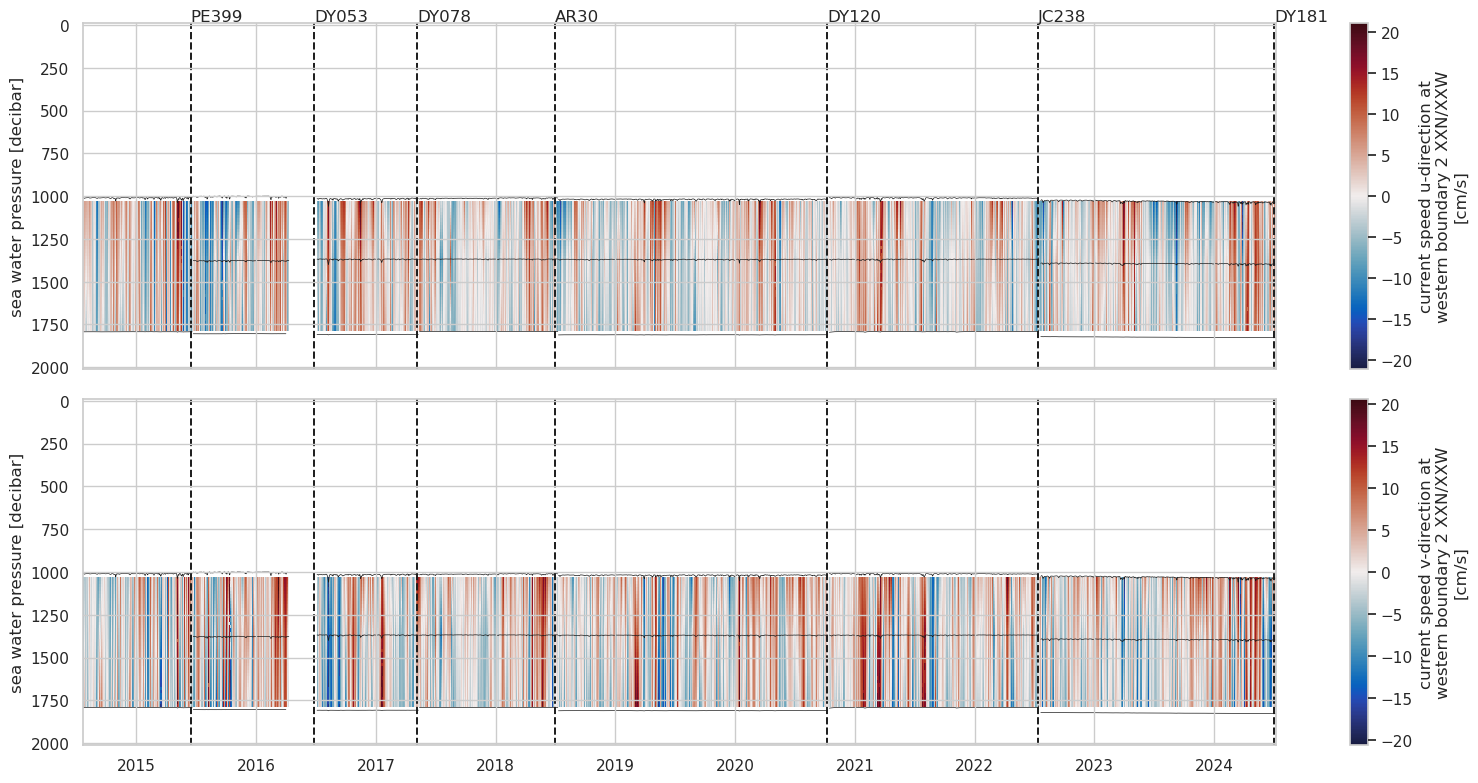

In [21]:
dim_x = 'TIME'
dim_y = 'PRES'
moor = 'WB2'
ds_RT['V_WEST_2'] = rtf.CM_linear_upper_values(ds_RT.V_WEST_2,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)
ds_RT['U_WEST_2'] = rtf.CM_linear_upper_values(ds_RT.U_WEST_2,moor,std_win,stddy_tol,nloop,dim_x,dim_y,graphics)

plot_moored_obs(ds_RT,moor,'velocity',ds_RT_stacked)

# Extrapolate hydro data by repeating upper values

In [22]:
def repeat_upper_values(var):
    mask = var.notnull()
    mask = mask + var.shift(PRES=-10).notnull()
    var = var.interpolate_na(
        dim='PRES',
        method="nearest",
        fill_value="extrapolate",
    ).where(mask)
    return var

In [23]:
ds_RT['TG_EAST'] = repeat_upper_values(ds_RT['TG_EAST'])
ds_RT['SG_EAST'] = repeat_upper_values(ds_RT['SG_EAST'])
ds_RT['TG_WEST'] = repeat_upper_values(ds_RT['TG_WEST'])
ds_RT['SG_WEST'] = repeat_upper_values(ds_RT['SG_WEST'])

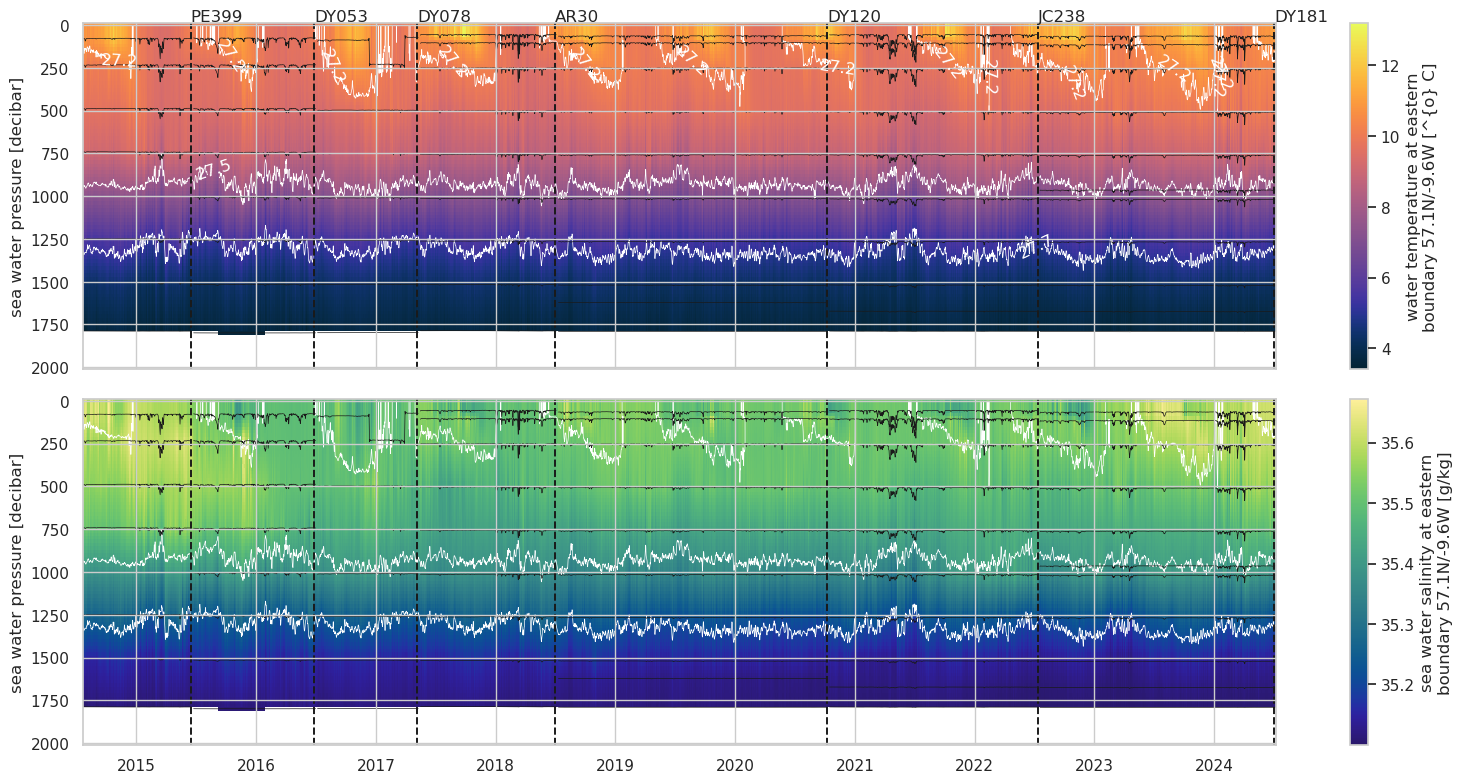

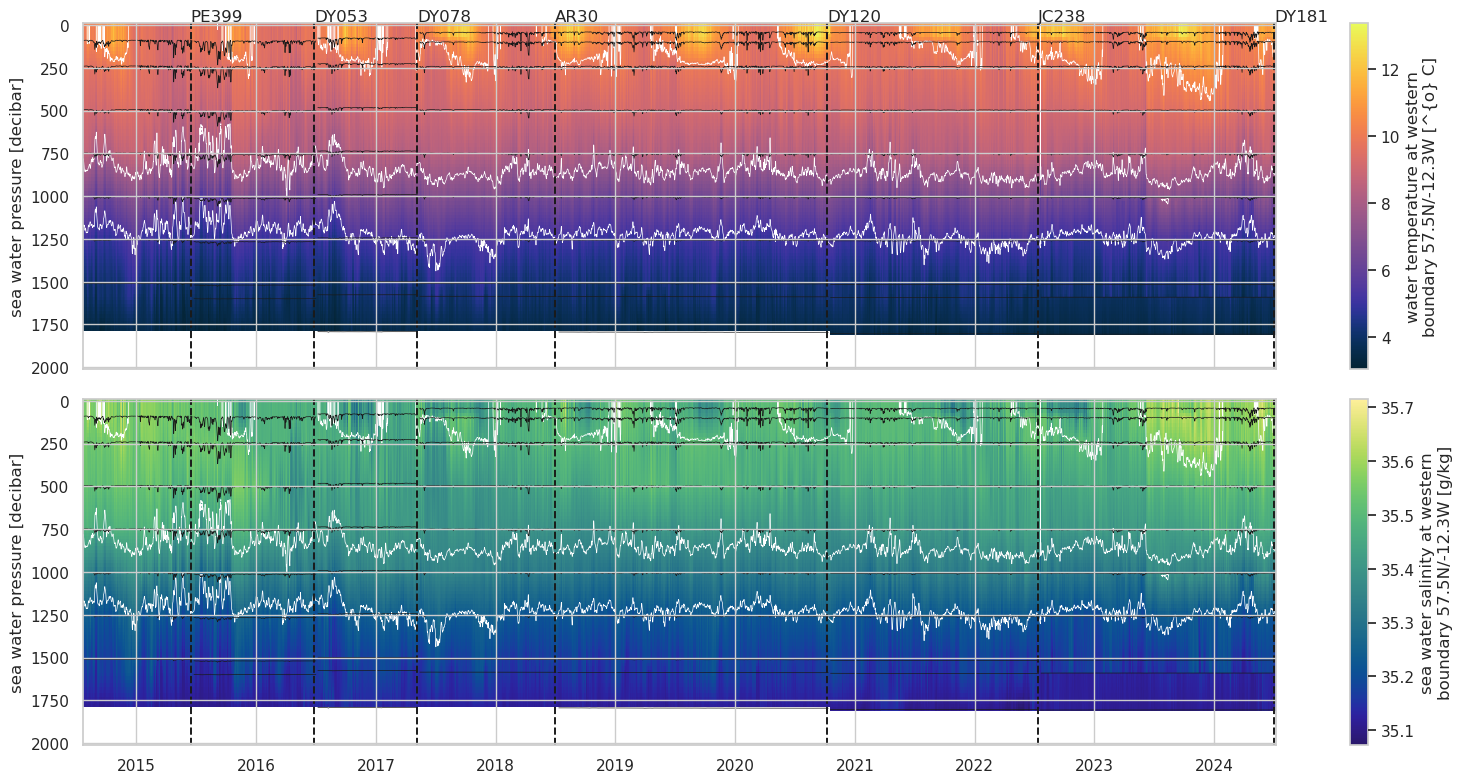

In [24]:
plot_moored_obs(ds_RT,'EB1','hydrography',ds_RT_stacked)
plot_moored_obs(ds_RT,'WB1','hydrography',ds_RT_stacked)

In [25]:
ds_RT.attrs['title']='CLASS Rockall Trough mooring data Jul 2014 to Jul 2022'
ds_RT.attrs['history']=f'Delayed time processed quality controlled Surface extrapolation done with. Surface extrapolation done with {script_name}.ipynb'
ds_RT.attrs['id']='Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.1'
ds_RT.attrs['time_coverage_start'] = f'{ds_RT.TIME.min().values}'
ds_RT.attrs['time_coverage_end'] = f'{ds_RT.TIME.max().values}'
ds_RT.attrs['date_modified'] = datetime.datetime.now().strftime("%d-%m-%YT%H:%M:%SZ")
ds_RT.attrs['contributor_name'] = 'Kristin Burmeister'
ds_RT.attrs['contributor_email'] = 'Kristin.Burmeister@sams.ac.uk'
ds_RT.to_netcdf((data_out_path/file_name_out))

# Plot for paper

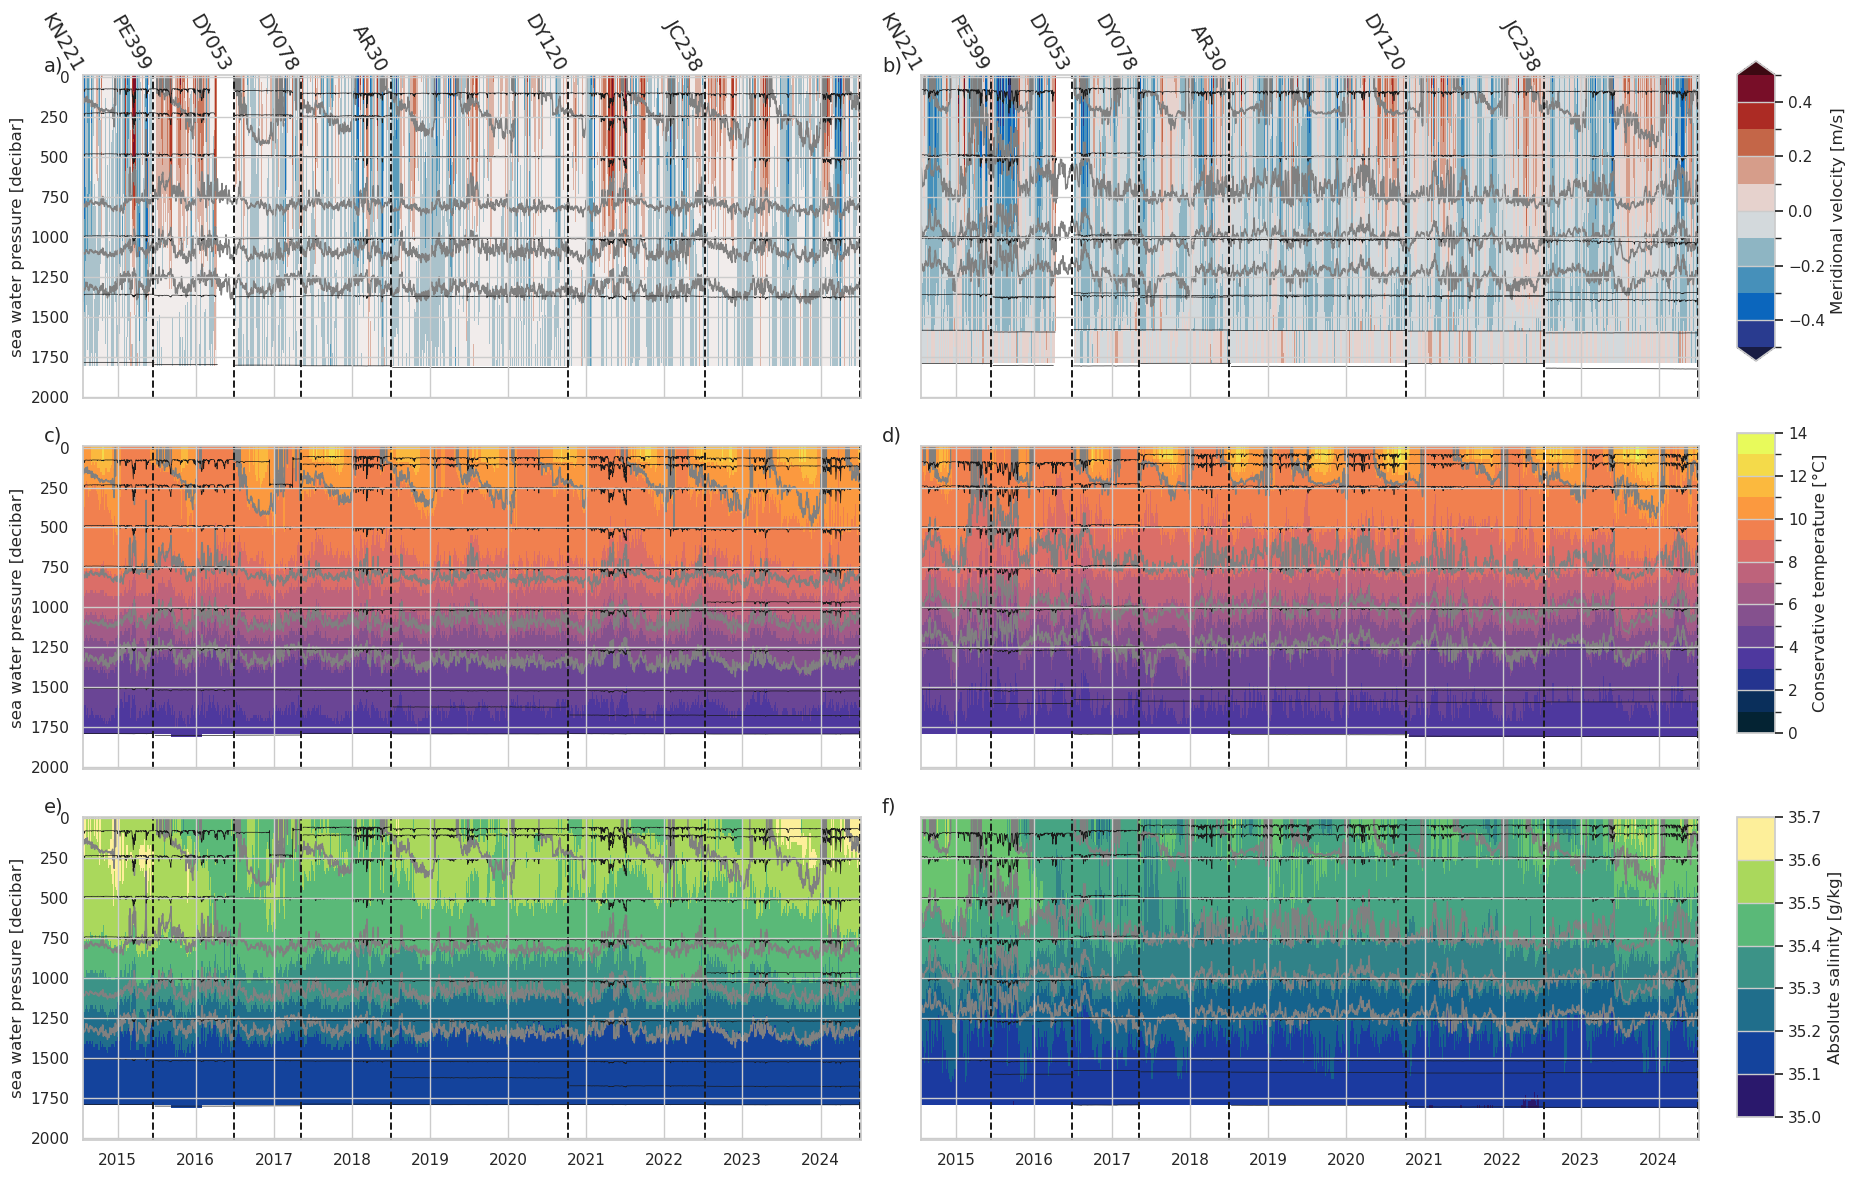

In [26]:
fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)

fig.savefig(fig_out_path/f'RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')

In [27]:
conda list

# packages in environment at /home/sa05af/.conda/envs/af_python3_12:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.12               h4ab18f5_0    conda-forge
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
aws-c-auth                0.7.31               h57bd9a3_0    conda-forge
aws-c-cal                 0.7.4                hfd43aa1_1    conda-forge
aws-c-common              0.9.28               hb9d3cd8_0    conda-forge
aws-c-compression         0.2.19               h756ea98_1    conda-forge
aws-c-event-stream        0.4.3                h29ce20c_2    conda-forge
aws-c-http                0.8.10               h5e77a74_0  